In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import arch
from arch import arch_model
from arch.univariate import GARCH
from scipy.stats import invweibull
from scipy.optimize import rosen, differential_evolution
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from empyrical.stats import conditional_value_at_risk
import datetime

In [2]:
# load the data

rate_df = pd.read_csv("C:/Users/severusbot/Documents/AMS_517/Frechet_Model/VIX_History.csv")


rate_df = rate_df[['DATE', 'OPEN', 'CLOSE']]
rate_df['OPEN'] = pd.to_numeric(rate_df['OPEN'])
rate_df['CLOSE'] = pd.to_numeric(rate_df['CLOSE'])
rate_df['DATE'] = pd.to_datetime(rate_df['DATE'])
rate_df['LOSS'] = (rate_df['CLOSE'] - rate_df['OPEN']) / rate_df['OPEN']
rate_df = rate_df[['DATE', 'LOSS']]

# find the max loss of each hour

rate_df.set_index('DATE', inplace = True)

maxloss_df = -rate_df.resample('W').min().dropna()
maxloss_df = maxloss_df[(maxloss_df.T != 0).any()]
display(maxloss_df)

# check for NaN

maxloss_df.isnull().values.any()



,LOSS
DATE,
1992-01-05,0.037583
1992-01-12,0.052709
1992-01-19,0.054593
1992-01-26,0.045040
1992-02-02,-0.032198
...,...
2022-03-20,0.099608
2022-03-27,0.082169
2022-04-03,0.113369


False

In [17]:
# fit the frechet distribution using 500 data points

global_shape,global_loc,global_scale = invweibull.fit(maxloss_df['LOSS'])
global_shape,global_loc,global_scale



C:\Users\severusbot\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\severusbot\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


(178.3271907708464, -5.4448501452637075, 5.4895798921203145)

In [4]:
# Time varying parameters

In [5]:
# we will use 500 samples

time_df = maxloss_df.copy()
time_df['Scale'] = np.nan
time_df['Shape'] = np.nan
time_df['Location'] = global_loc

def fit_invweibull(val):

    shape, loc, scale = invweibull.fit(val, floc = global_loc)
    return 1/shape, loc, scale

for x in range(1, 501):
    time_df.iloc[500+x, 2], loc, time_df.iloc[500+x, 1] = fit_invweibull(maxloss_df['LOSS'][:500+x])

time_df = time_df.bfill(axis = 'rows')
time_df = time_df.reset_index()

#time_df

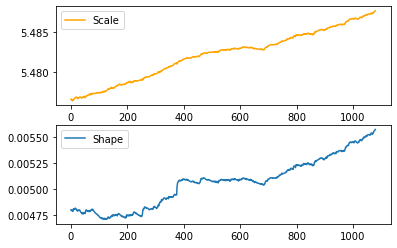

In [16]:
fig,ax = plt.subplots(2,1)

ax[1].plot(time_df['Shape'][500:].values, label='Shape')
ax[0].plot(time_df['Scale'][500:].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()

In [7]:
# estimating coefficients using the training set
temp_df = time_df.copy(deep = True)
temp_df = temp_df.dropna()

exog = -temp_df['LOSS'][499:-1].values

mod = AutoReg(np.log(temp_df['Shape'][500:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
shape_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  501
Model:                   AutoReg-X(1)   Log Likelihood                2784.589
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Mon, 18 Apr 2022   AIC                            -13.960
Time:                        20:53:00   BIC                            -13.927
Sample:                             1   HQIC                           -13.947
                                  501                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0108      0.008      1.351      0.177      -0.005       0.026
y.L1           0.9981      0.002    660.575      0.000       0.995       1.001
x1            -0.0223      0.001    -17.394      0.0

C:\Users\severusbot\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


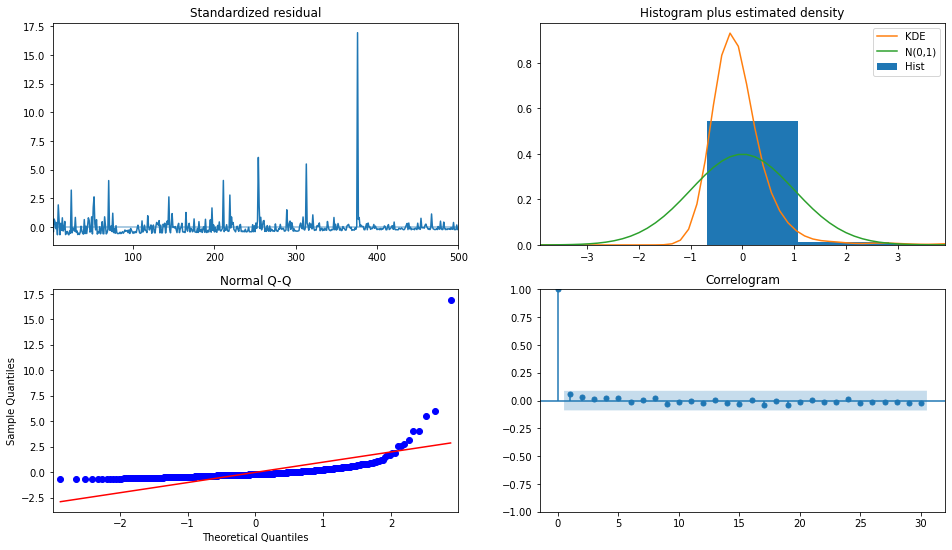

In [8]:
fig = plt.figure(figsize = (16, 9))
fig = res.plot_diagnostics(fig = fig, lags = 30)

In [9]:
exog = -temp_df['LOSS'][499:-1].values

mod = AutoReg(np.log(temp_df['Scale'][500:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
scale_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  501
Model:                   AutoReg-X(1)   Log Likelihood                5680.928
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Mon, 18 Apr 2022   AIC                            -25.546
Time:                        20:53:00   BIC                            -25.512
Sample:                             1   HQIC                           -25.532
                                  501                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.001      5.908      0.000       0.003       0.005
y.L1           0.9979      0.000   2637.834      0.000       0.997       0.999
x1            -0.0002   3.92e-06    -44.081      0.0

C:\Users\severusbot\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


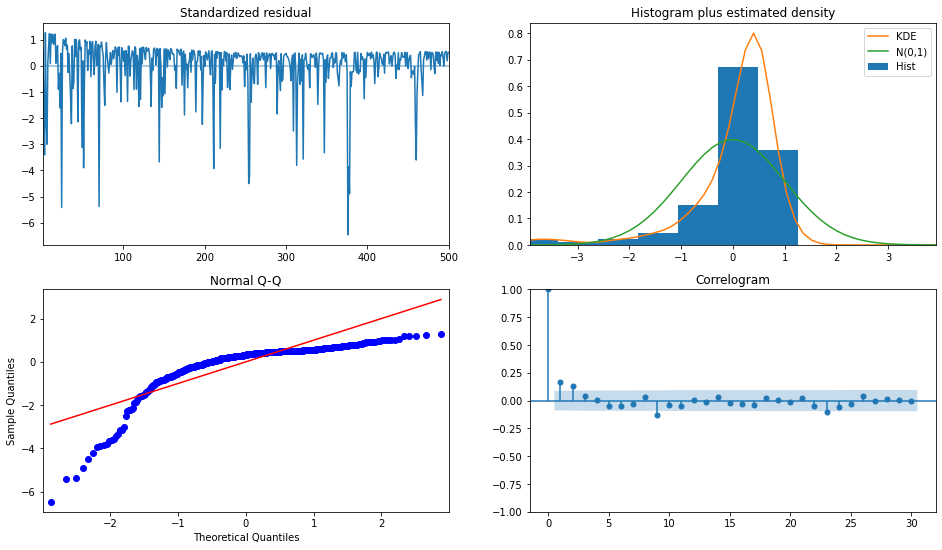

In [10]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [11]:
# Using the test data set

#pd.set_option('display.max_rows', None)
cvar1=pd.Series([])
cvar2=pd.Series([])
cvar3=pd.Series([])

counter = 0

for x,row in time_df.iterrows():
    if not np.isnan(row['Shape']) and not np.isnan(row['Scale']) :
        counter=counter+1
        cvar1=cvar1.append(pd.Series([np.nan],index=[x]))
        cvar2=cvar2.append(pd.Series([np.nan],index=[x]))
        cvar3=cvar3.append(pd.Series([np.nan],index=[x]))
        continue
    #print(np.exp(shape_params[0]+shape_params[1]*np.log(time_df['Shape'][counter-1])+shape_params[2]*np.exp(-time_df['Loss'][counter-1]) ))

    time_df.at[x, 'Shape'] = np.exp(shape_params[0]+shape_params[1]*np.log(time_df['Shape'][counter-1])+shape_params[2]*np.exp(-time_df['LOSS'][counter-1]) )# walk forward from our eqns
    time_df.at[x, 'Scale'] = np.exp(scale_params[0]+scale_params[1]*np.log(time_df['Scale'][counter-1])+scale_params[2]*np.exp(-time_df['LOSS'][counter-1]) )# walk forward 
    
    # empirical cvars for each fitted period outside of train set #1 
    cvar1=cvar1.append(pd.Series([conditional_value_at_risk(time_df['LOSS'][:counter],0.90)],index=[x]))
    cvar2=cvar2.append(pd.Series([conditional_value_at_risk(time_df['LOSS'][:counter],0.95)],index=[x]))
    cvar3=cvar3.append(pd.Series([conditional_value_at_risk(time_df['LOSS'][:counter],0.99)],index=[x]))
    
    counter=counter+1
time_df['cvar_0.90']=cvar1
time_df['cvar_0.95']=cvar2
time_df['cvar_0.99']=cvar3
    
#time_df

<ipython-input-11-c7f4e5cece83>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar1=pd.Series([])
<ipython-input-11-c7f4e5cece83>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar2=pd.Series([])
<ipython-input-11-c7f4e5cece83>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar3=pd.Series([])


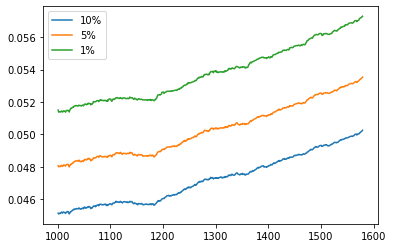

In [12]:
plt.plot(time_df['cvar_0.90'],label='10%')
plt.plot(time_df['cvar_0.95'],label='5%')
plt.plot(time_df['cvar_0.99'],label='1%')
plt.legend()

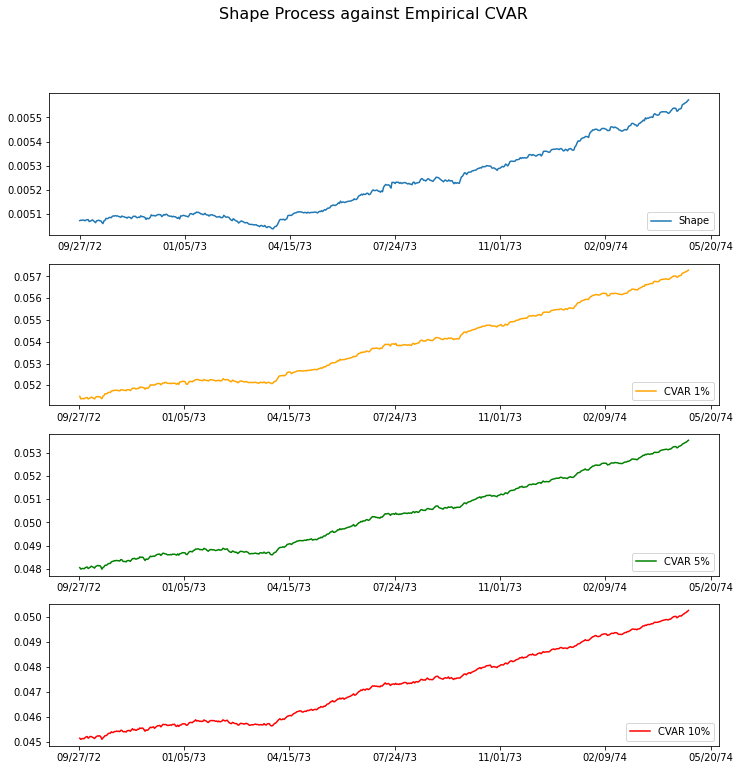

In [13]:
fig,ax = plt.subplots(4,1,figsize=(12,12))

fig.suptitle("Shape Process against Empirical CVAR",fontsize=16)
ax[0].plot(time_df['Shape'][1000:], label='Shape')
ax[1].plot(time_df['cvar_0.99'][1000:], label='CVAR 1%',color='orange') 
ax[2].plot(time_df['cvar_0.95'][1000:], label='CVAR 5%',color='green') 
ax[3].plot(time_df['cvar_0.90'][1000:], label='CVAR 10%',color='red') 
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))
ax[2].xaxis.set_major_formatter(DateFormatter("%D"))
ax[3].xaxis.set_major_formatter(DateFormatter("%D"))

In [14]:
print(np.corrcoef(time_df['Shape'][1001:],time_df['cvar_0.90'][1001:]))
print(np.corrcoef(time_df['Shape'][1001:],time_df['cvar_0.95'][1001:]))
print(np.corrcoef(time_df['Shape'][1001:],time_df['cvar_0.99'][1001:]))

[[1.         0.98721422]
 [0.98721422 1.        ]]
[[1.         0.98751214]
 [0.98751214 1.        ]]
[[1.         0.98874184]
 [0.98874184 1.        ]]


In [15]:
am = arch_model(maxloss_df['LOSS'][1000:],rescale=True)  # generate 
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6936.438995955365
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2675.7928399508105
Iteration:      3,   Func. Count:     24,   Neg. LLF: 282.55134885101734
Iteration:      4,   Func. Count:     30,   Neg. LLF: 277.26245884264296
Iteration:      5,   Func. Count:     35,   Neg. LLF: 277.2553903722626
Iteration:      6,   Func. Count:     40,   Neg. LLF: 277.25157272829745
Iteration:      7,   Func. Count:     45,   Neg. LLF: 277.25142186817345
Iteration:      8,   Func. Count:     50,   Neg. LLF: 277.2514153494928
Iteration:      9,   Func. Count:     54,   Neg. LLF: 277.25141541394925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 277.2514153494928
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   LOSS   R-squared:          